# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
from gravity import GravitySimulation
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


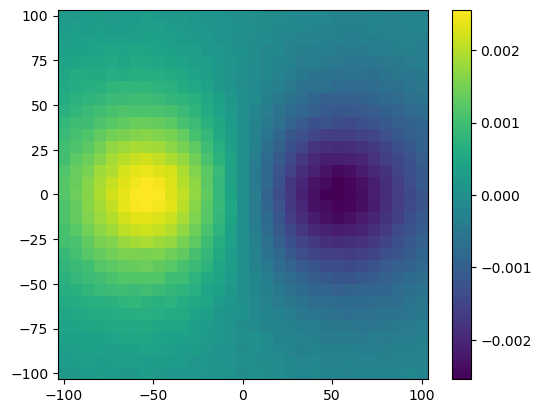

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
# h = [(5.0, 40)]
h = [(10.0, 20)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 8,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20       -100.00        100.00     10.00     10.00    1.00
   y     20       -100.00        100.00     10.00     10.00    1.00
   z     20       -200.00          0.00     10.00     10.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7f603967efd0>,)

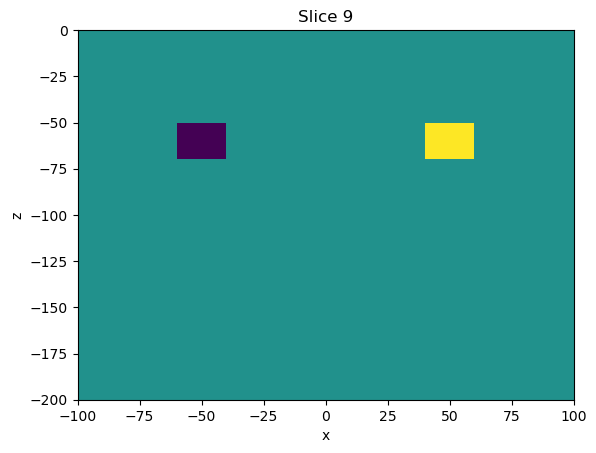

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

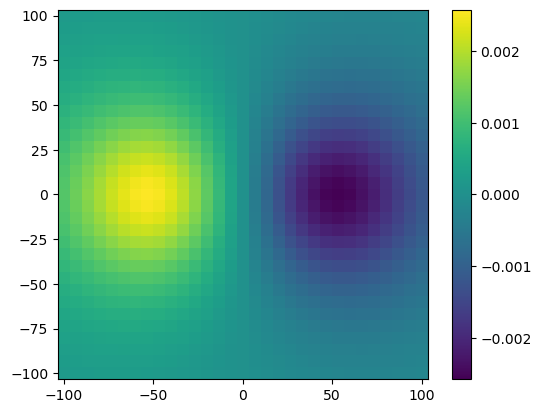

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Sparse gravity inversion

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = GravitySimulation(simulation_simpeg)

In [15]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [16]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
sparse_smallness = ii.SparseSmallness(
    n_params=simulation.n_params, 
    norm=1,
    model_previous=None,
    weights=volume_weights * depth_weights,
    irls=False, # Start with IRLS deactivated
)

In [17]:
beta_0 = 1e4
regularization = beta_0 * sparse_smallness
phi = data_misfit + regularization
phi

φd(m) + 1.00e+04 φss(m)

In [ ]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Minimizer
minimizer = ii.ConjugateGradient()

# Stopping criteria
smallness_not_changing = ii.ObjectiveChanged(sparse_smallness, rtol=1e-3)

# Define irls directive
irls_directive = ii.IrlsFull(
    sparse_smallness,
    data_misfit=data_misfit,
    regularization=regularization,
)

# Define sparse inversion
sparse_inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[irls_directive],
    stopping_criteria=smallness_not_changing,
    cache_models=True,
    max_iterations=80,
)

# Add columns to log
sparse_inversion.log.columns["irls active?"] = lambda _, __: sparse_smallness.irls"
sparse_inversion.log.columns["irls threshold"] = lambda _, __: sparse_smallness.threshold"
sparse_inversion.log.columns["|phi_m - phi_m*| / |phi_m*|"] = lambda _, model: smallness_not_changing.ratio(model)"

In [19]:
model = sparse_inversion.run()

Output()

KeyboardInterrupt: 

In [20]:
sparse_inversion.log.table

┏━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃      ┃          ┃          ┃          ┃          ┃          ┃          ┃             ┃            ┃ |phi_m -    ┃
┃      ┃          ┃          ┃          ┃          ┃          ┃          ┃ irls        ┃ irls       ┃ phi_m*| /   ┃
┃ iter ┃ β        ┃ φ_d      ┃ φ_m      ┃ β φ_m    ┃ φ        ┃ χ        ┃ active?     ┃ threshold  ┃ |phi_m*|    ┃
┡━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 0    │ 1.00e+04 │ 1.67e+06 │ 0.00e+00 │ 0.00e+00 │ 1.67e+06 │ 1.74e+03 │ False       │ 1.00e-08   │ nan         │
│ 1    │ 1.00e+04 │ 4.39e+05 │ 3.85e+01 │ 3.85e+05 │ 8.24e+05 │ 4.57e+02 │ False       │ 1.00e-08   │ inf         │
│ 2    │ 5.00e+03 │ 2.33e+05 │ 6.74e+01 │ 3.37e+05 │ 5.70e+05 │ 2.42e+02 │ False       │ 1.00e-08   │ 7.53e-01    │
│ 3    │ 2.50e+03 │ 1.11e+05 │ 1.01e+02 │ 2.54e+05 │ 3.65e+05 │ 1.15e+02 │ False       │ 1.00e-08   │ 5.05e-01    │
│ 4    │ 1.25e+03 │ 4.70e+04 │ 1.37e+02 │ 1.71e+05 │ 2.18e+05 │ 4.89e+01 │ False       │ 1.00e-08   │ 3.48e-01    │
│ 5    │ 6.25e+02 │ 1.79e+04 │ 1.69e+02 │ 1.05e+05 │ 1.23e+05 │ 1.86e+01 │ False       │ 1.00e-08   │ 2.33e-01    │
│ 6    │ 3.12e+02 │ 6.47e+03 │ 1.94e+02 │ 6.05e+04 │ 6.70e+04 │ 6.73e+00 │ False       │ 1.00e-08   │ 1.47e-01    │
│ 7    │ 1.56e+02 │ 2.52e+03 │ 2.11e+02 │ 3.29e+04 │ 3.54e+04 │ 2.63e+00 │ False       │ 1.00e-08   │ 8.81e-02    │
│ 8    │ 7.81e+01 │ 1.26e+03 │ 2.22e+02 │ 1.73e+04 │ 1.86e+04 │ 1.31e+00 │ False       │ 1.00e-08   │ 5.19e-02    │
│ 9    │ 3.91e+01 │ 8.49e+02 │ 2.29e+02 │ 8.94e+03 │ 9.78e+03 │ 8.83e-01 │ False       │ 1.00e-08   │ 3.21e-02    │
│ 10   │ 3.91e+01 │ 4.63e+05 │ 9.98e+03 │ 3.90e+05 │ 8.53e+05 │ 4.82e+02 │ True        │ 3.24e-03   │ 4.26e+01    │
│ 11   │ 1.47e+01 │ 1.82e+05 │ 2.16e+04 │ 3.17e+05 │ 4.99e+05 │ 1.89e+02 │ True        │ 3.24e-03   │ 1.16e+00    │
│ 12   │ 5.54e+00 │ 5.74e+04 │ 3.49e+04 │ 1.93e+05 │ 2.51e+05 │ 5.98e+01 │ True        │ 3.24e-03   │ 6.17e-01    │
│ 13   │ 2.12e+00 │ 1.50e+04 │ 4.66e+04 │ 9.86e+04 │ 1.14e+05 │ 1.56e+01 │ True        │ 3.24e-03   │ 3.36e-01    │
│ 14   │ 8.55e-01 │ 3.98e+03 │ 5.42e+04 │ 4.63e+04 │ 5.03e+04 │ 4.15e+00 │ True        │ 3.24e-03   │ 1.63e-01    │
│ 15   │ 4.12e-01 │ 1.66e+03 │ 5.79e+04 │ 2.38e+04 │ 2.55e+04 │ 1.73e+00 │ True        │ 3.24e-03   │ 6.87e-02    │
│ 16   │ 2.59e-01 │ 1.14e+03 │ 5.95e+04 │ 1.54e+04 │ 1.66e+04 │ 1.18e+00 │ True        │ 3.24e-03   │ 2.72e-02    │
│ 17   │ 1.94e-01 │ 9.58e+02 │ 6.02e+04 │ 1.17e+04 │ 1.27e+04 │ 9.97e-01 │ True        │ 3.24e-03   │ 1.32e-02    │
│ 18   │ 1.59e-01 │ 8.74e+02 │ 6.07e+04 │ 9.65e+03 │ 1.05e+04 │ 9.09e-01 │ True        │ 3.24e-03   │ 7.93e-03    │
│ 19   │ 1.59e-01 │ 9.27e+02 │ 6.94e+04 │ 1.10e+04 │ 1.20e+04 │ 9.65e-01 │ True        │ 2.59e-03   │ 1.44e-01    │
│ 20   │ 1.59e-01 │ 9.80e+02 │ 7.78e+04 │ 1.24e+04 │ 1.33e+04 │ 1.02e+00 │ True        │ 2.08e-03   │ 1.20e-01    │
│ 21   │ 1.28e-01 │ 8.88e+02 │ 7.84e+04 │ 1.01e+04 │ 1.10e+04 │ 9.24e-01 │ True        │ 2.08e-03   │ 8.21e-03    │
│ 22   │ 1.28e-01 │ 9.22e+02 │ 8.52e+04 │ 1.09e+04 │ 1.19e+04 │ 9.60e-01 │ True        │ 1.66e-03   │ 8.65e-02    │
│ 23   │ 1.28e-01 │ 9.49e+02 │ 9.00e+04 │ 1.16e+04 │ 1.25e+04 │ 9.88e-01 │ True        │ 1.33e-03   │ 5.64e-02    │
│ 24   │ 1.06e-01 │ 8.77e+02 │ 9.06e+04 │ 9.57e+03 │ 1.04e+04 │ 9.13e-01 │ True        │ 1.33e-03   │ 6.84e-03    │
│ 25   │ 1.06e-01 │ 8.95e+02 │ 9.31e+04 │ 9.83e+03 │ 1.07e+04 │ 9.32e-01 │ True        │ 1.06e-03   │ 2.73e-02    │
│ 26   │ 1.06e-01 │ 9.12e+02 │ 9.40e+04 │ 9.92e+03 │ 1.08e+04 │ 9.49e-01 │ True        │ 8.50e-04   │ 9.02e-03    │
│ 27   │ 1.06e-01 │ 9.28e+02 │ 9.36e+04 │ 9.88e+03 │ 1.08e+04 │ 9.65e-01 │ True        │ 6.80e-04   │ 3.56e-03    │
│ 28   │ 1.06e-01 │ 9.45e+02 │ 9.26e+04 │ 9.78e+03 │ 1.07e+04 │ 9.83e-01 │ True        │ 5.44e-04   │ 1.05e-02    │
│ 29   │ 8.70e-02 │ 8.93e+02 │ 9.32e+04 │ 8.11e+03 │ 9.0

In [35]:
column = np.array([float(v) for v in log.iloc[:, -1]])
column

array([     nan,      inf, 7.53e-01, 5.05e-01, 3.48e-01, 2.33e-01,
       1.47e-01, 8.81e-02, 5.19e-02, 3.21e-02, 4.26e+01, 1.16e+00,
       6.17e-01, 3.36e-01, 1.63e-01, 6.87e-02, 2.72e-02, 1.32e-02,
       7.93e-03, 1.44e-01, 1.20e-01, 8.21e-03, 8.65e-02, 5.64e-02,
       6.84e-03, 2.73e-02, 9.02e-03, 3.56e-03, 1.05e-02, 5.76e-03,
       1.53e-02, 1.48e-02, 1.45e-02, 5.54e-03, 1.51e-02, 1.31e-02,
       5.43e-03, 1.31e-02, 1.12e-02, 5.43e-03, 1.11e-02, 5.59e-03,
       1.03e-02, 8.76e-03, 5.80e-03, 8.65e-03, 6.33e-03, 7.97e-03,
       6.95e-03, 6.79e-03, 6.61e-03, 7.78e-03, 5.74e-03, 5.28e-03,
       8.73e-03, 4.19e-03, 3.97e-03, 3.80e-03, 3.54e-03, 9.30e-03,
       1.85e-03, 1.90e-03, 1.95e-03, 1.91e-03])

In [21]:
sparse_inversion.stopping_criteria.info(model)

[ ] ObjectiveChanged
├── Condition: |φ(m) - φ(m_prev)| <= max(|φ(m_prev)| * rtol, atol)
├── |φ(m) - φ(m_prev)| = 7.31e+04
├── |φ(m_prev)|        = 8.21e+04
├── rtol               = 1.00e-03
└── atol               = 0.00e+00

In [22]:
log = pd.DataFrame(sparse_inversion.log.log).set_index("iter")
log

,β,φ_d,φ_m,β φ_m,φ,χ,irls active?,irls threshold,|phi_m - phi_m*| / |phi_m*|
iter,,,,,,,,,
0,10000.000000,1.667546e+06,0.000000,0.000000,1.667546e+06,1735.219131,False,1.00e-08,nan
1,10000.000000,4.389534e+05,38.478020,384780.200009,8.237336e+05,456.767350,False,1.00e-08,inf
2,5000.000000,2.329218e+05,67.438364,337191.820291,5.701136e+05,242.374404,False,1.00e-08,7.53e-01
3,2500.000000,1.107991e+05,101.489970,253724.925065,3.645240e+05,115.295650,False,1.00e-08,5.05e-01
4,1250.000000,4.697144e+04,136.833743,171042.178538,2.180136e+05,48.877673,False,1.00e-08,3.48e-01
...,...,...,...,...,...,...,...,...,...
59,0.012823,9.231507e+02,82750.179830,1061.124640,1.984275e+03,0.960615,True,6.27e-06,9.30e-03
60,0.012823,9.198673e+02,82596.982155,1059.160151,1.979027e+03,0.957198,True,5.02e-06,1.85e-03
61,0.012823,9.182137e+02,82440.083148,1057.148199,1.975362e+03,0.955477,True,4.01e-06,1.90e-03


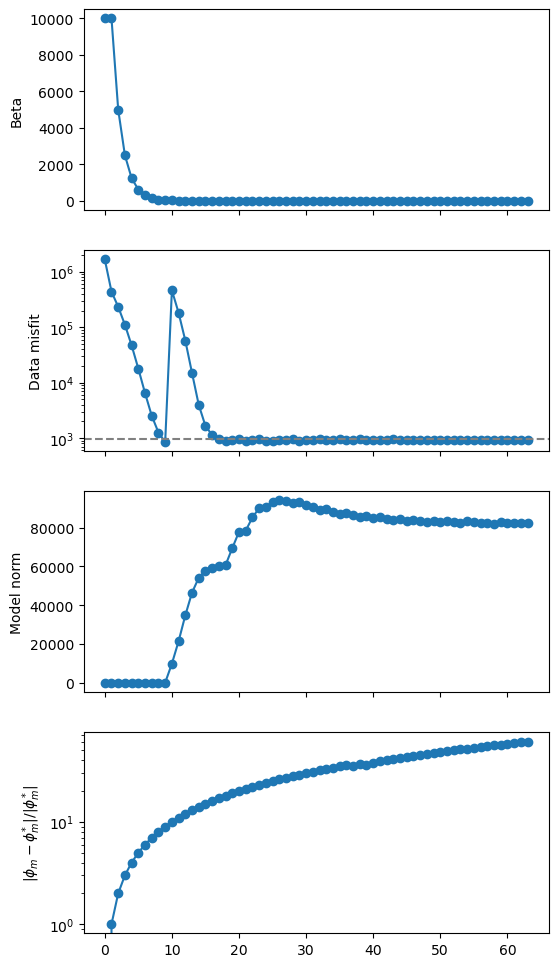

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 12))
axes[0].plot(log.index, log.β, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.φ_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.φ_m, "o-")
axes[2].set_ylabel("Model norm")

axes[3].plot(log.index, log["|phi_m - phi_m*| / |phi_m*|"], "o-")
axes[3].set_ylabel(r"$|\phi_m - \phi_m^{*}| / |\phi_m^{*}|$")
axes[3].set_yscale("log")

plt.show()

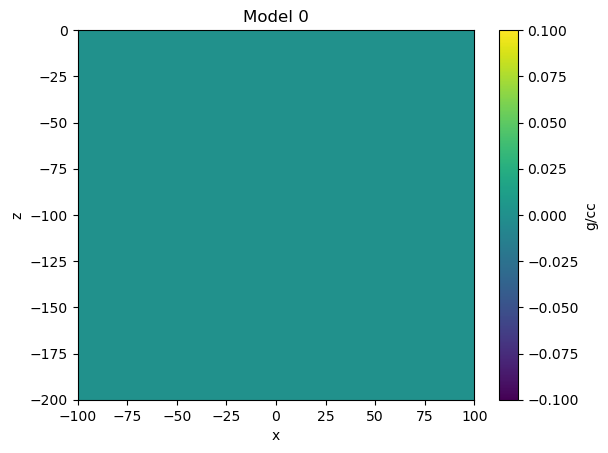

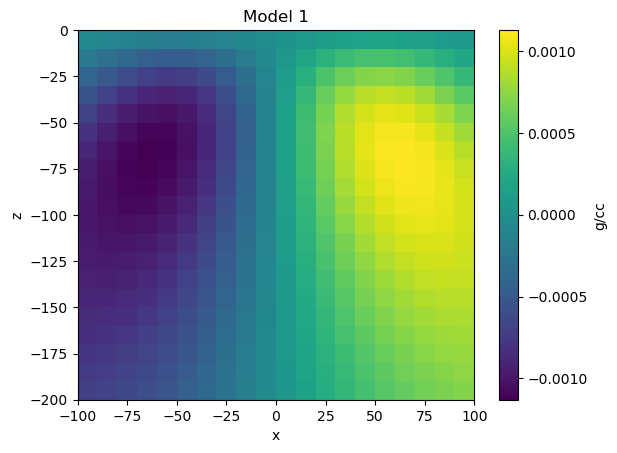

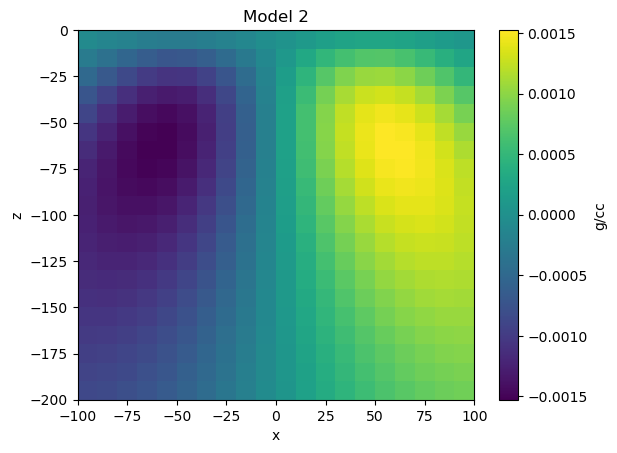

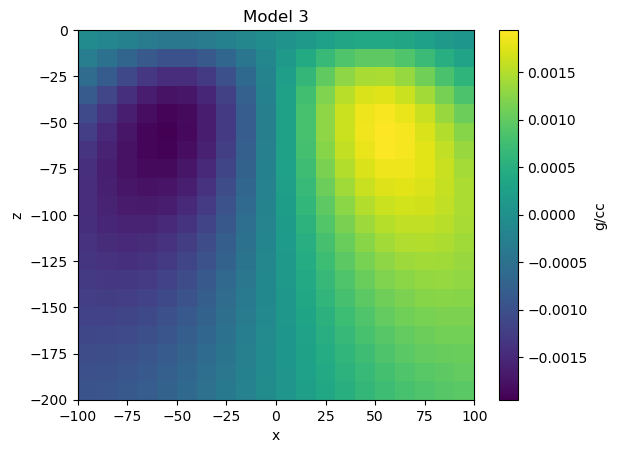

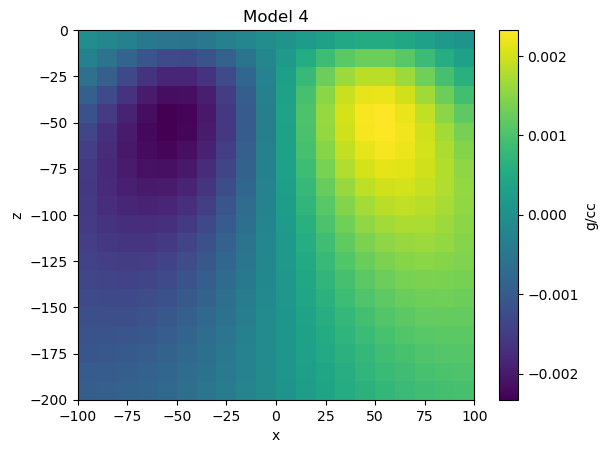

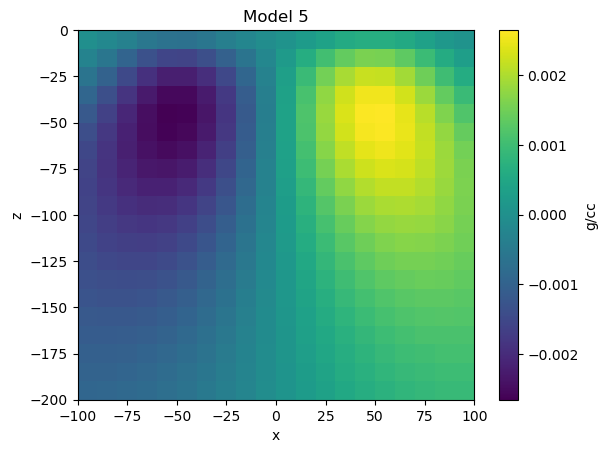

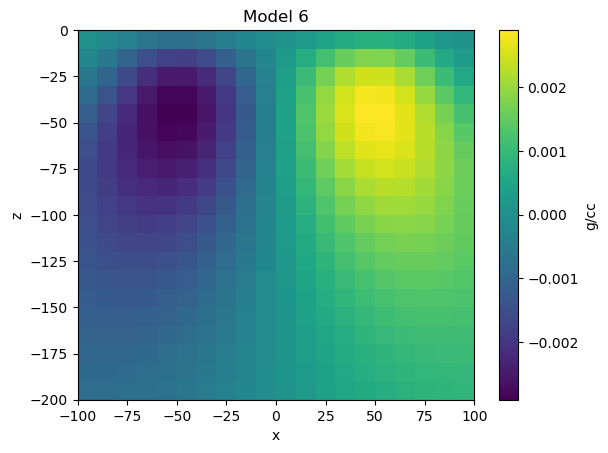

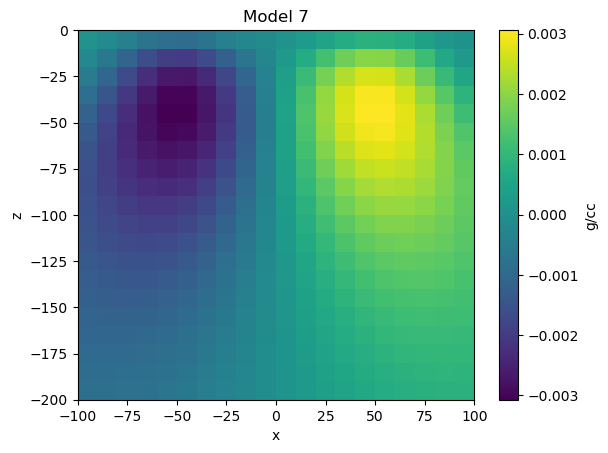

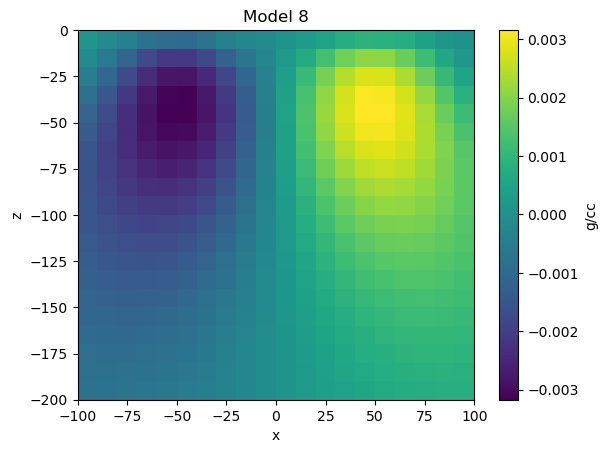

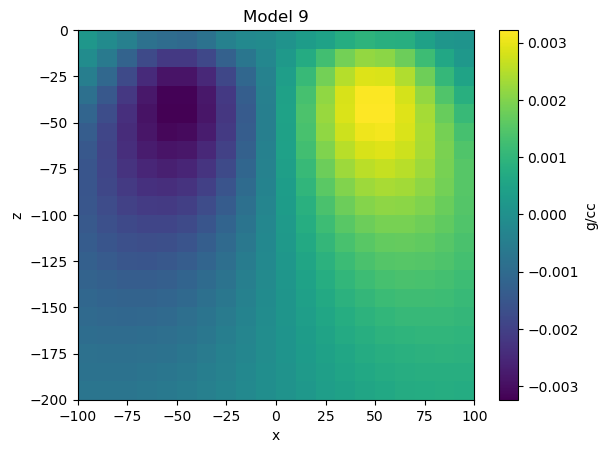

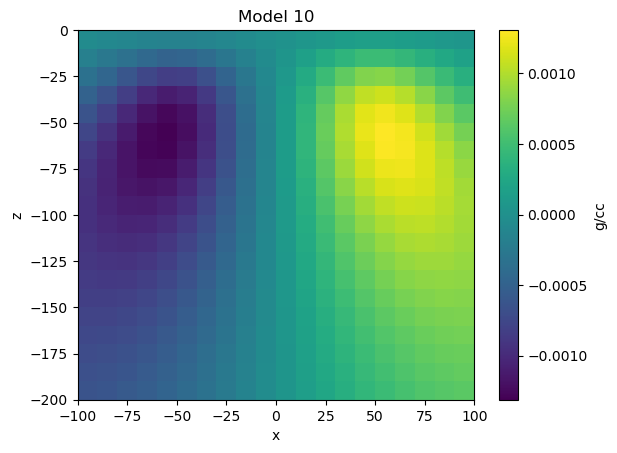

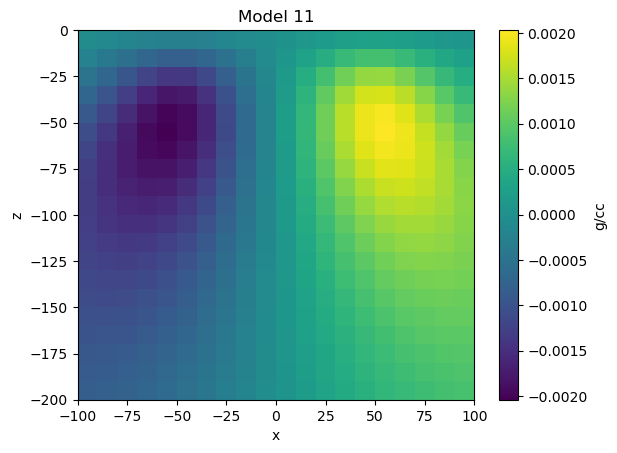

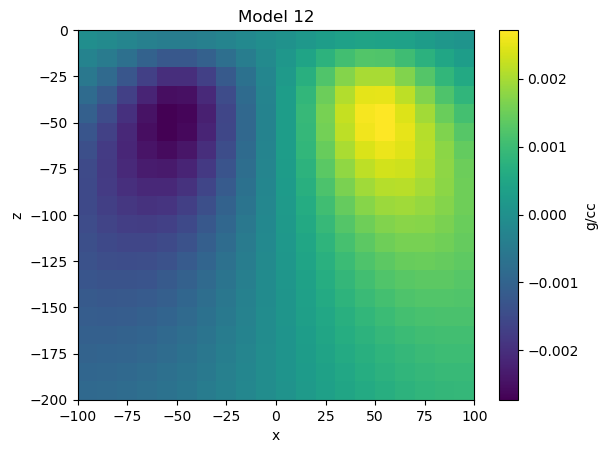

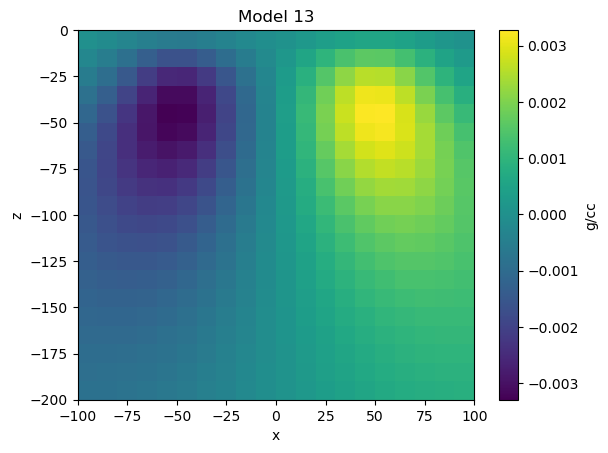

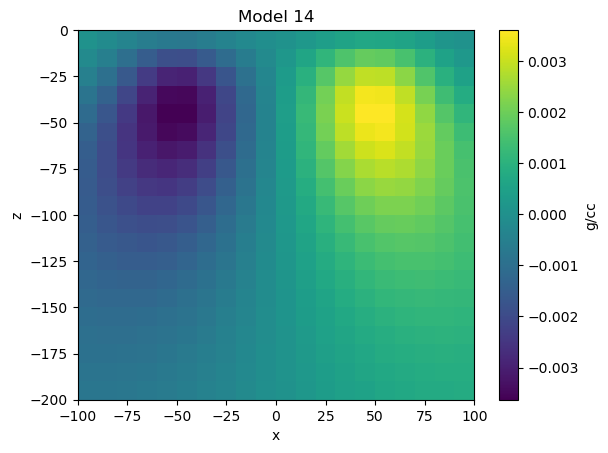

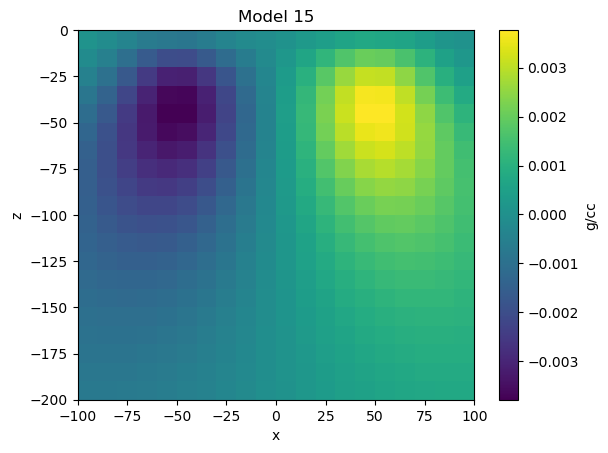

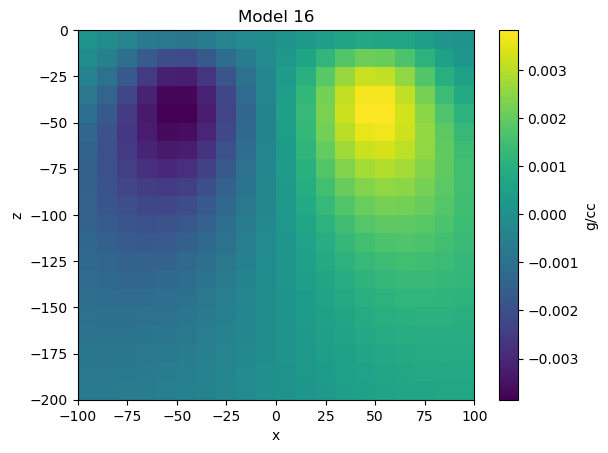

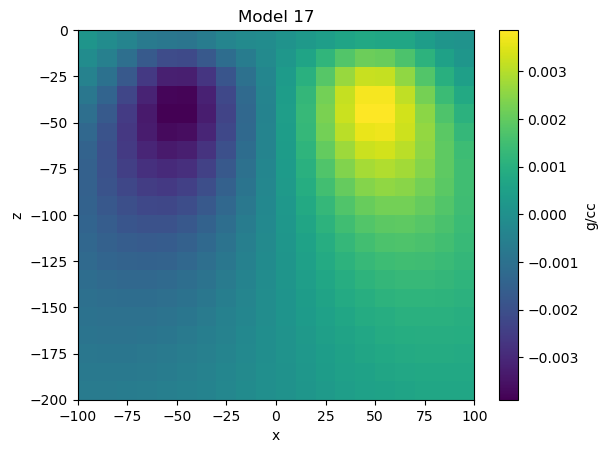

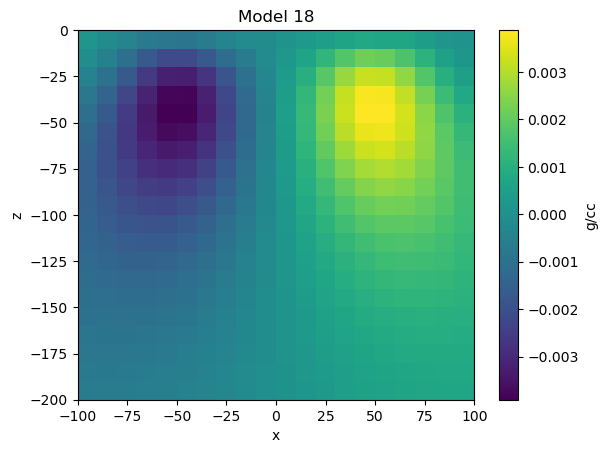

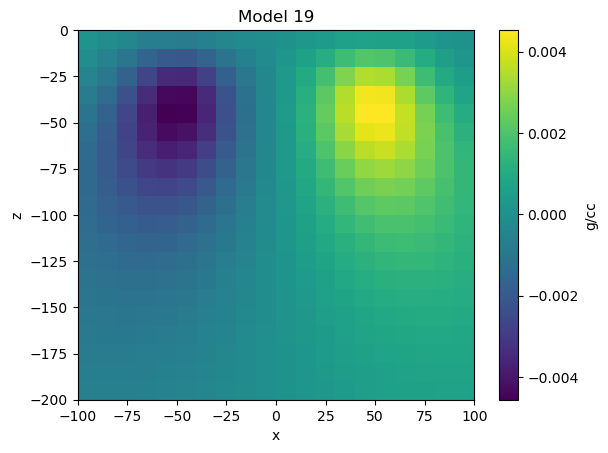

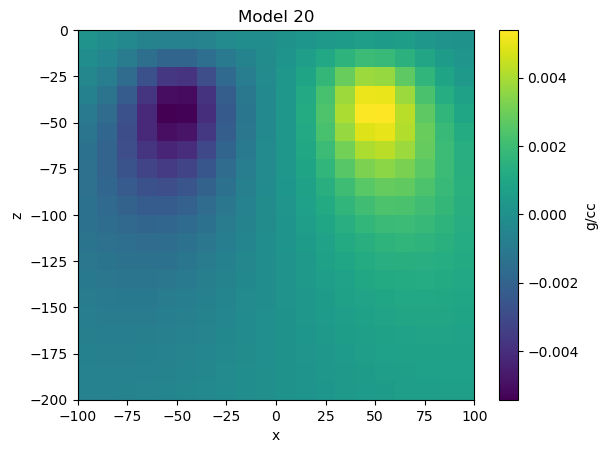

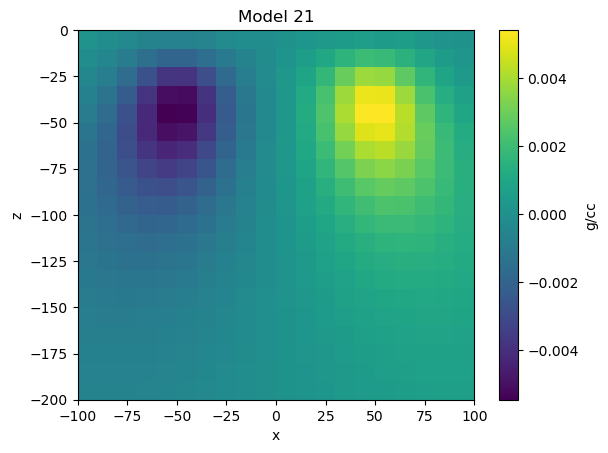

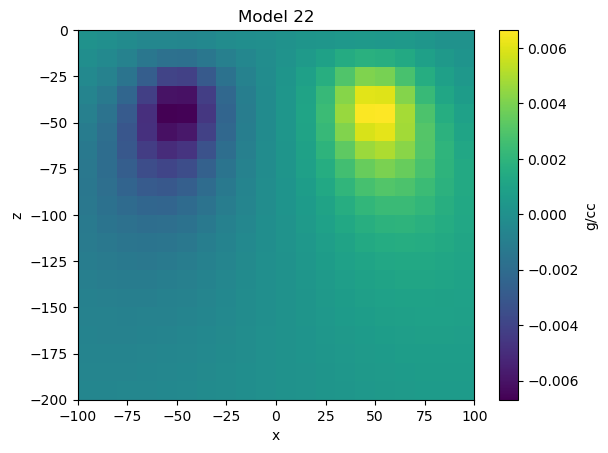

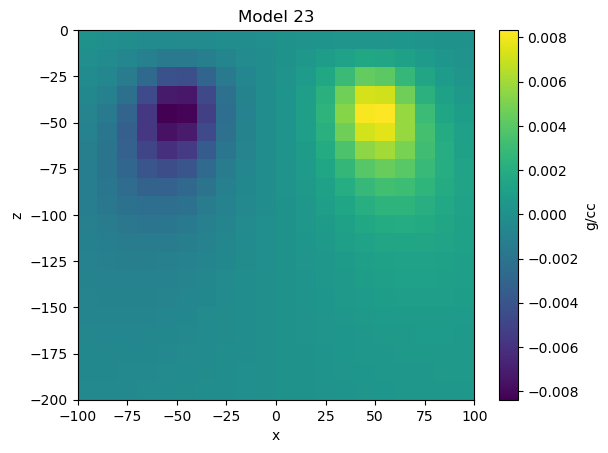

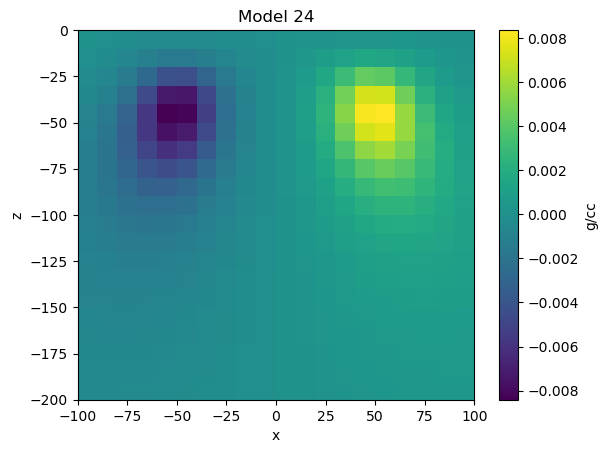

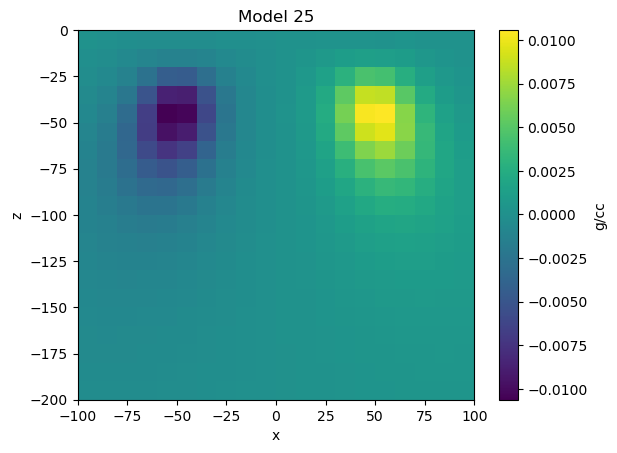

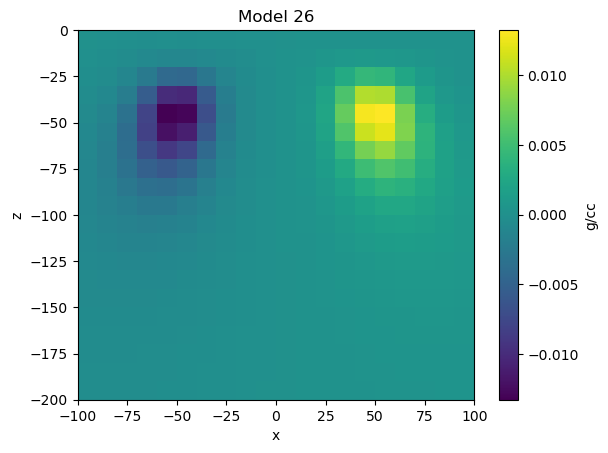

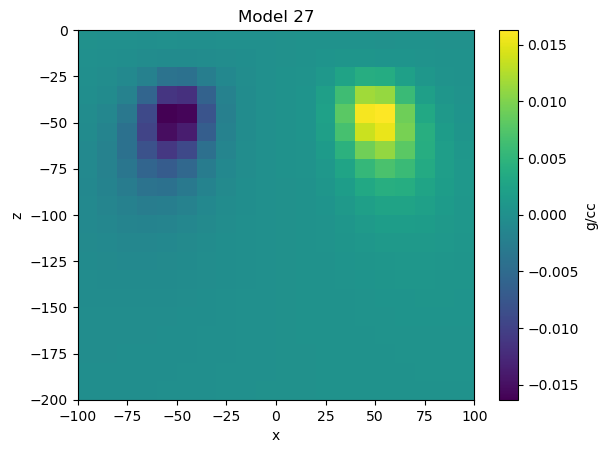

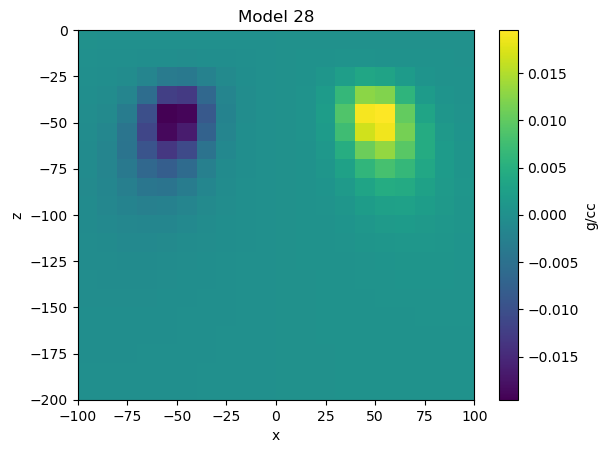

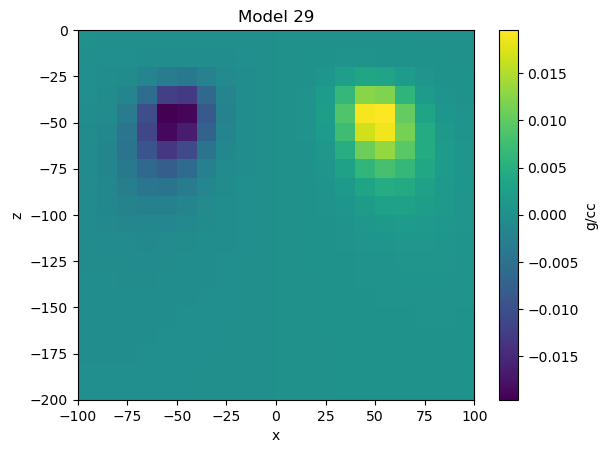

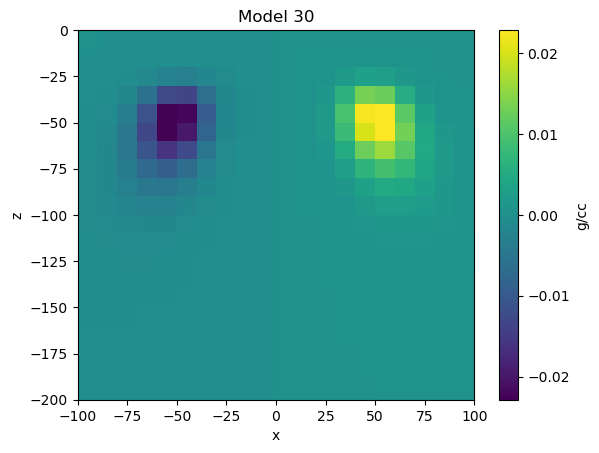

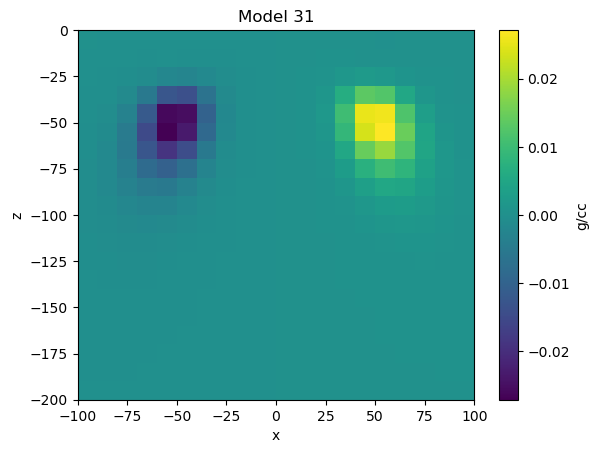

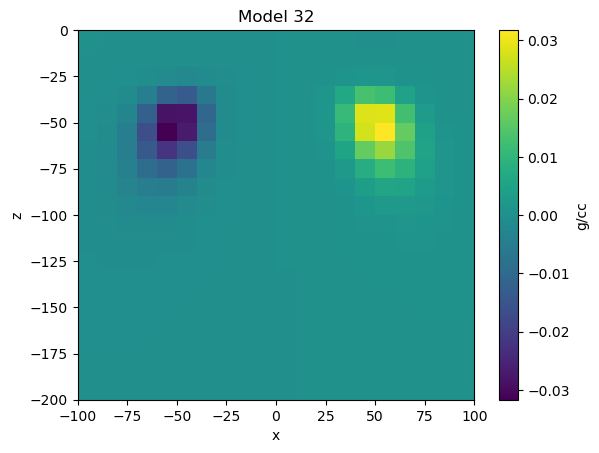

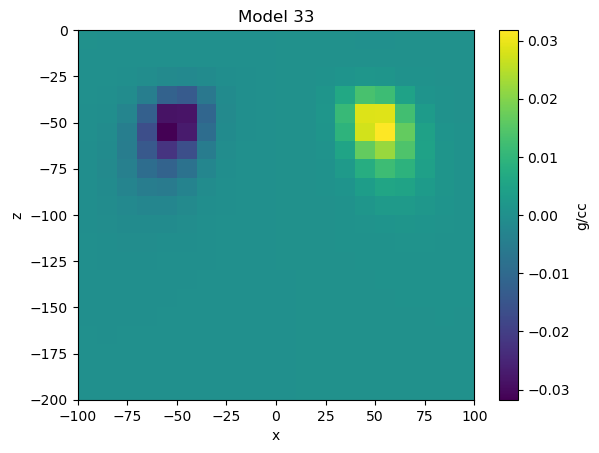

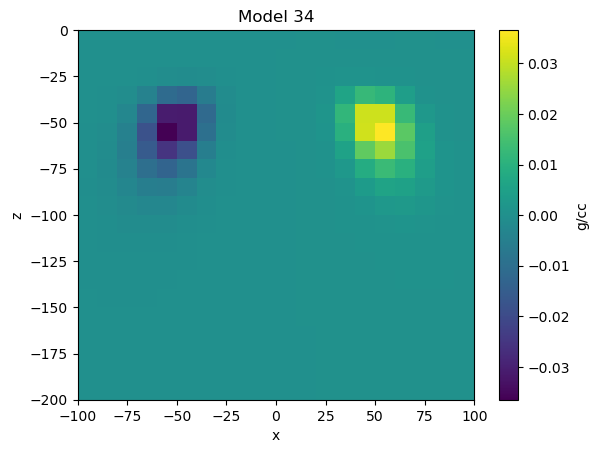

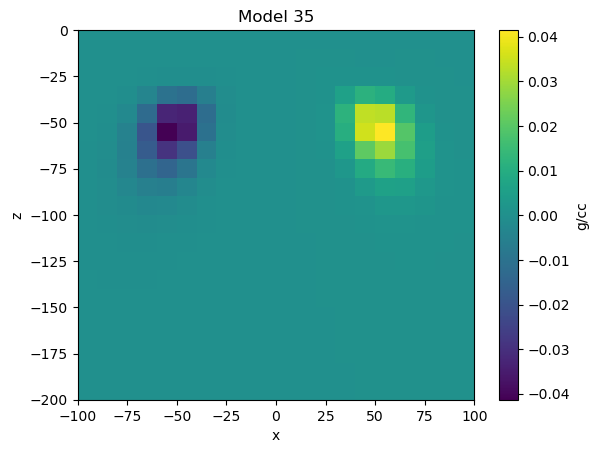

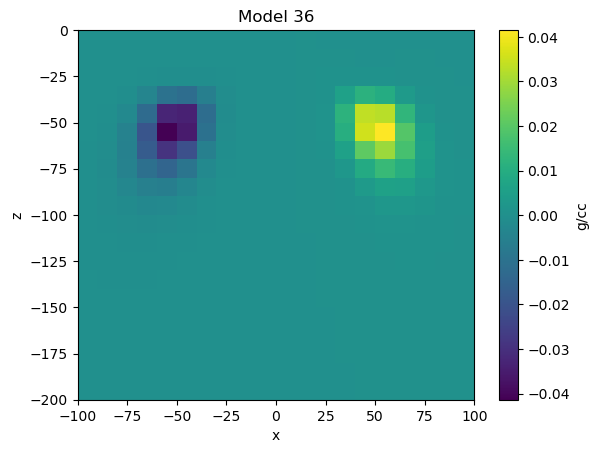

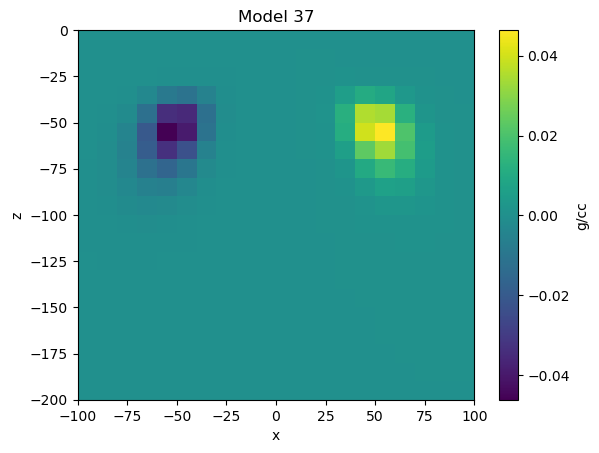

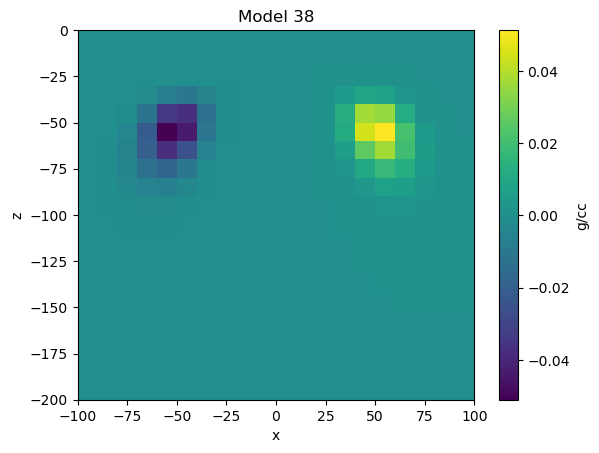

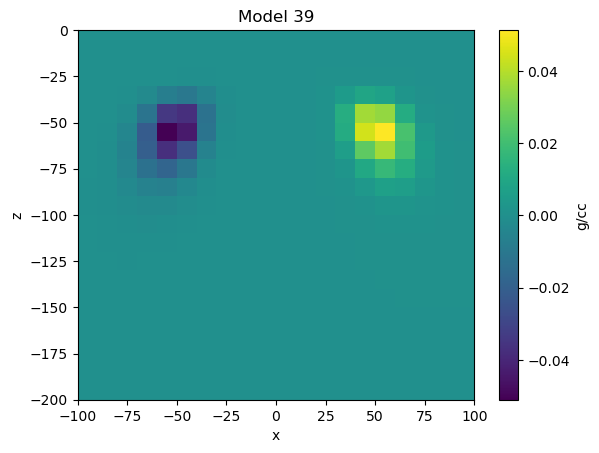

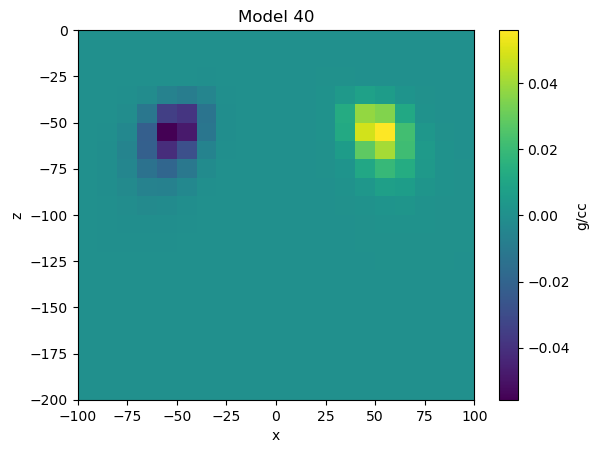

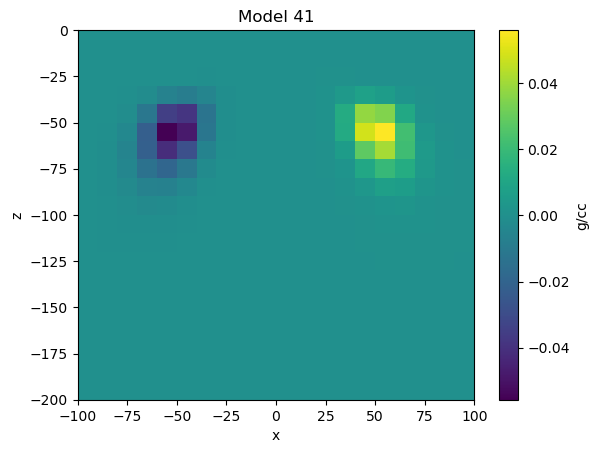

In [ ]:
for i, model in enumerate(sparse_inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()

In [ ]:
models = sparse_inversion.models

diffs = [
    np.linalg.norm(models[i+1] - models[i]) / np.linalg.norm(models[i])
    for i in range(len(models) - 1)
]

/tmp/ipykernel_1649/3298380557.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  np.linalg.norm(models[i+1] - models[i]) / np.linalg.norm(models[i])


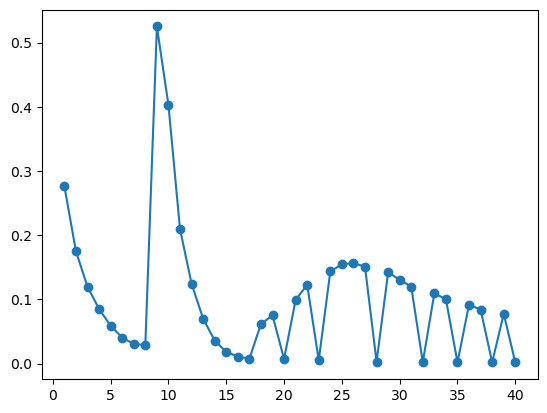

In [ ]:
plt.plot(diffs, "o-")
plt.show()